# 1.CNN卷积神经网络

## 引入
1、传统的词袋模型或者连续词袋模型都可以通过构建一个全连接的神经网络对句子进行情感标签的分类，但是这样存在一个问题，我们通过激活函数可以让某些结点激活（例如一个句子里”not”,”hate”这样的较强的特征词），但是由于在这样网络构建里，句子中__词语的顺序被忽略__，也许同样两个句子都出现了not和hate但是一个句子（I do not hate this movie）表示的是good的情感，另一个句子（I hate this movie and will not choose it）表示的是bad的情感。其实很重要的一点是在刚才上述模型中我们无法捕获像not hate这样由连续两个词所构成的关键特征的词的含义。<br>


2、在语言模型里__n-gram模型__是可以用来解决，想法其实就是将连续的两个词作为一个整体纳入到模型中，这样确实能够解决我们刚才提出的问题，例如“don’t love”，“not the best”。但是问题又来了，如果我们使用n-gram模型，实际训练时的__需要估计的参数过多__是一个非常大的问题。另外一点，相似的词语在这样的模型中不能共享例如参数权重等，这样就会导致相似词__无法获得交互信息__。

3、利用__卷积神经网络__实际上是可以解决上述的两个问题。

## 模型介绍

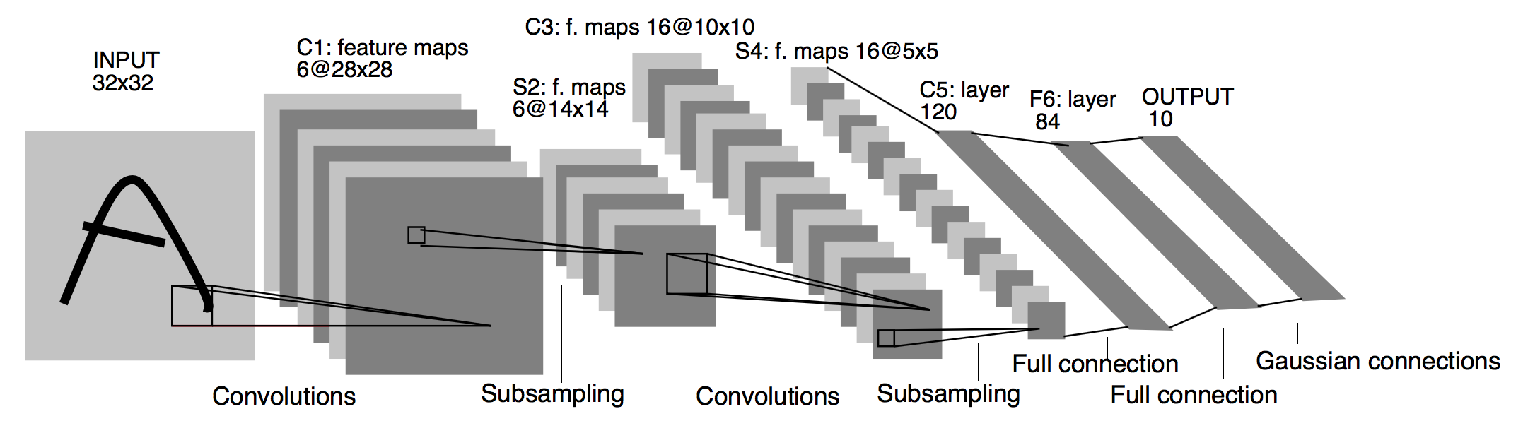

### １、卷积核

卷积网络（convolutional net），由两部分组成：一组权重（就像第 5 章中给神经元分配的权重），一个激活函数。不像传统的前馈网络那样对每个元素（图像中的每个像素）分配权重，而是定义了一组在图像上移动的过滤器（filter，也称为卷积核、滤波器或者特征检测器）。在前向传播过程中，对于给定的输入样本，卷积核中的权重值不变。

(1)平移不变性;不管出现在图像中的哪个位置，神经⽹络的底层应该对相同的图像区域做出类似的响应。<br>
(2)局部性：神经⽹络的底层应该只探索输⼊图像中的局部区域，而不考虑图像远处区域的内容，这就是“局部性”原则。最终，这些局部特征可以融会贯通，在整体上做出预测。

### ２、步长

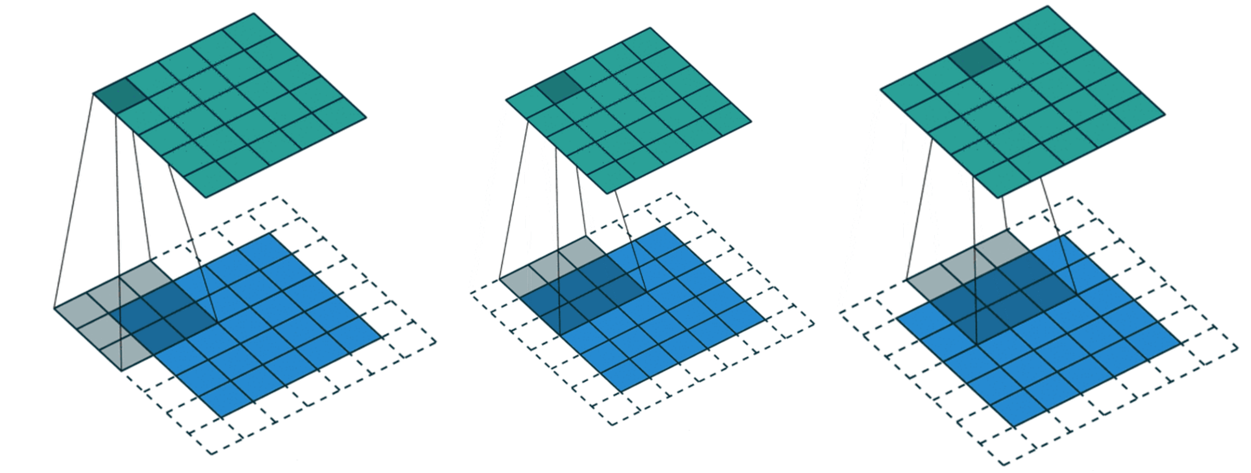

在滑动阶段，移动的距离是一个参数，一般不会超过卷积核宽度，每个卷积“走”的距离称为__步长__，通常设置为 1。

### ３、填充

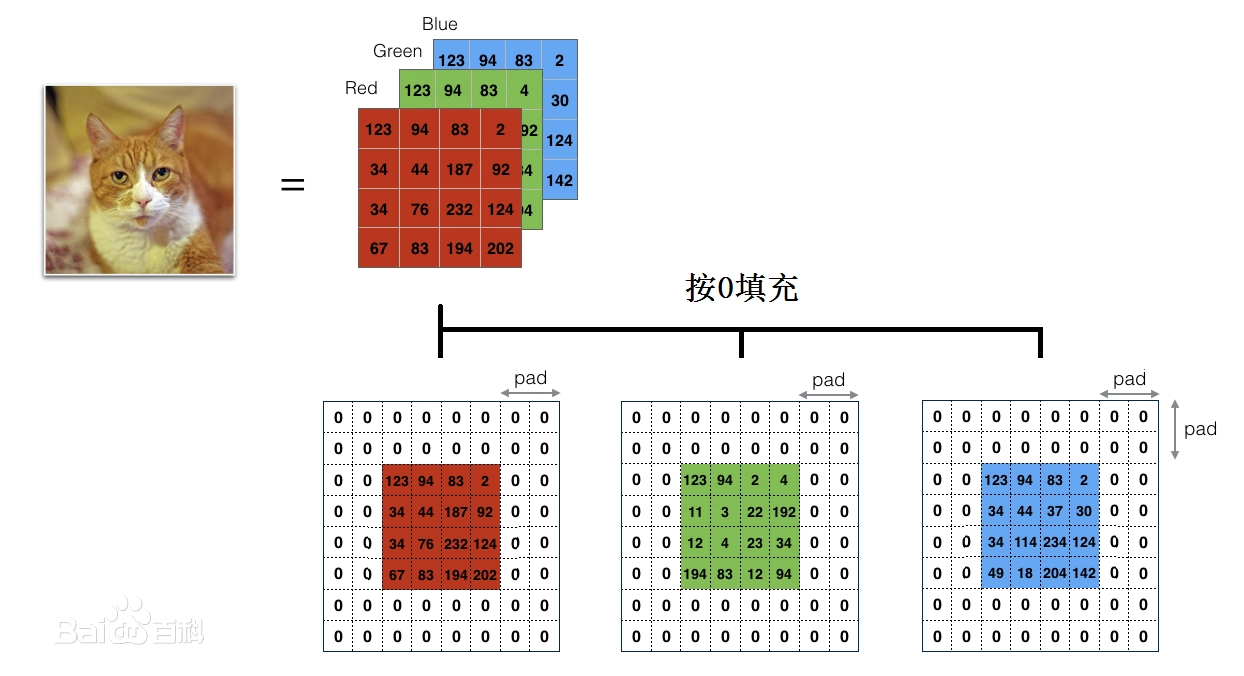

如果大家从输入图像的左上角开始一个 3 × 3的卷积核，每次移动一个像素，当卷积核的最右侧边缘到达输入图像的最右侧边缘时停止，那么
__输出的“图像”将比原图像窄两个像素__。Keras 提供了处理这个问题的工具。


１、第一个策略是忽略输出维度变小的问题。在 Keras 中，可以设置参数 padding = 'valid'。使用这种方法时，需要注意下一层输入的维度。这种策
略的缺点是重叠位置上的内部数据点被多次传递到每个卷积核上，原始输入的边缘数据将被欠采样。

２、另一个策略称为__填充__（padding），即向输入数据的外部边缘添加足够多的数据，使边缘上的
第一个数据点可以被视为内部数据点进行处理。这种策略的缺点是向输入数据中添加了可能不相
关的内容，导致偏离了输出结果。

## 卷积在图像和文字处理中的差异

对于图像这种二维输入使用的是二维卷积，但对于文本，词之间的相对垂直关系可以是任意的，只取决于页面宽度，因此关联信息主要体现在
“水平”方向上。所以做的是__一维卷积__。如果将文本想象为图像，则“第二个”维度是__词向量的全长__，大家只需要关心卷积核的“宽度”。

### 1.嵌入层（embedding）
预训练词向量作为嵌入层，__将数据中所有词分别表示成向量形式__，得到一个词向量矩阵,该矩阵可以是静态的（static），用预训练词向量初始化embeddings，训练过程中不再更新，也可以是非静态（non-static），根据反向传播更新。

### 2.卷积层
选择好了输入，接下来就是卷积。不同于图像处理的卷积，CNN对NLP的卷积核大小有要求，一般来说，__卷积核的长度和词向量的维度应该是一致的__。比如一个词向量是N维的，那么卷积核就应该是X*N维的，如果X==2，即所以卷积就是提取2个词之间的特征。


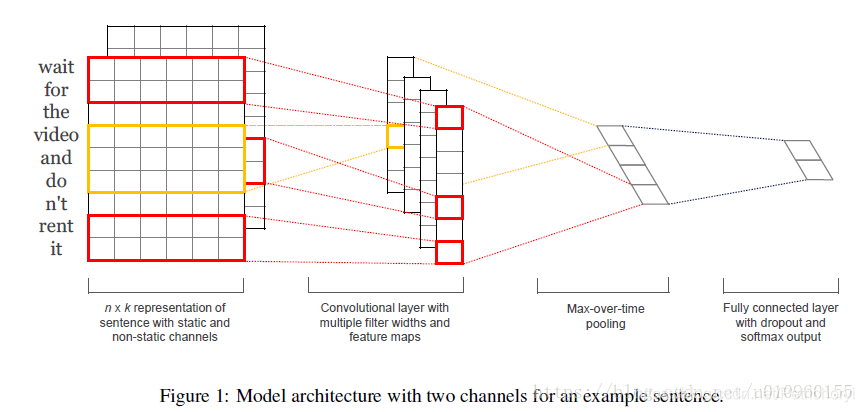

### 3.池化层
__Max-pooling__最为常见，最大池化是取整个区域的最大值作为特征，在自然语言处理中常用于__分类问题__，希望观察到的特征是__强特征__，以便可以区分出是哪一个类别。__Average-pooling__通常是用于__主题模型__，常常是一个句子不止一个主题标签，如果是使用Max-pooling的话信息过少，所以使用Average的话可以广泛反映这个区域的特征。<br>
在图像处理中，池化区域通常是 2 × 2 的像素窗口（它们不像卷积核那样相互重叠），而在一维卷积中它们是__一维窗口__（如 1 × 2 或 1 × 3）。

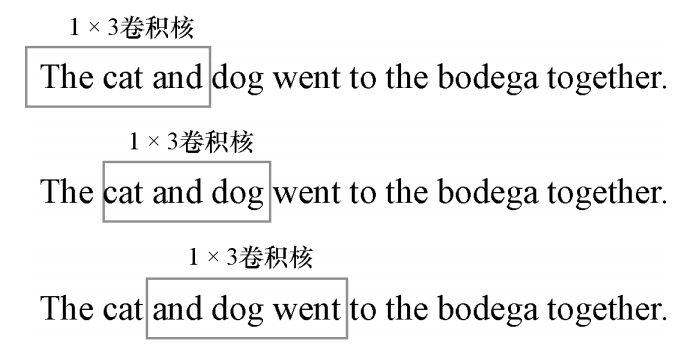

##  Keras 实现：准备数据

Keras 文档提供的卷积神经网络分类器设计了一个__一维卷积网络__

In [1]:
import numpy as np
import pandas as pd
import re #正则表达式的模块
from gensim.models.keyedvectors import KeyedVectors 
from nltk.tokenize import TreebankWordTokenizer # 切词

导入数据，一个电影评论数据集。

In [2]:
path = "F:\\研一下课件\\自然语言处理\\英文文本分析\\"
train=pd.read_csv(path+"labeledTrainData.tsv",sep='\t',encoding="ISO-8859-1")

In [3]:
sentence=train['review'][:1000] # 选取前 1000 行评论
label=train['sentiment'][:1000] # 对应的前1000评论的标签，0代表负向评论，1代表正向评论

In [4]:
#print(type(sentence))
sentence[0] # train_sentence为<class 'pandas.core.series.Series'>类型

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

下载基于GoogleNews超大语料库训练好的词向量的模型，每个词向量维度为300。

In [5]:
path = "F:\\googlenews"
word_vectors = KeyedVectors.load_word2vec_format(path+'\\GoogleNews-vectors-negative300.bin',binary=True, limit=200000)

In [6]:
# GoogleNews的词向量模型举例
word_vectors['phone'] 
# 为<class 'numpy.ndarray'> 数据类型

array([-0.01446533, -0.12792969, -0.11572266, -0.22167969, -0.07373047,
       -0.05981445, -0.10009766, -0.06884766,  0.14941406,  0.10107422,
       -0.03076172, -0.03271484, -0.03125   , -0.10791016,  0.12158203,
        0.16015625,  0.19335938,  0.0065918 , -0.15429688,  0.03710938,
        0.22753906,  0.1953125 ,  0.08300781,  0.03686523, -0.02148438,
        0.01483154, -0.21289062,  0.16015625,  0.29101562, -0.03149414,
       -0.05883789,  0.04418945, -0.11767578, -0.12597656,  0.08447266,
       -0.10791016, -0.11279297,  0.17871094,  0.04467773,  0.17675781,
       -0.17089844, -0.02160645, -0.00061417, -0.17480469, -0.04760742,
        0.06835938, -0.0546875 ,  0.04467773, -0.19628906, -0.18554688,
       -0.10839844, -0.06030273,  0.11474609,  0.08544922,  0.05859375,
        0.23925781, -0.07080078,  0.11816406, -0.11132812,  0.08300781,
       -0.04394531,  0.00970459, -0.1484375 ,  0.265625  , -0.13769531,
        0.23535156, -0.19824219,  0.31445312,  0.02734375,  0.16

定义一个函数用于切词和文本向量化。

In [7]:
'''
tokenize_and_vectorize 用于将传入的所有句子，切词，转换为词向量，然后以列表的形式输出。
'''
def tokenize_and_vectorize(dataset): 
    tokenizer = TreebankWordTokenizer()    #TreebankWordTokenizer 分词器，它内置了多种常见的英语分词规则。
    vectorized_data = []
    expected = []
    for i in range(len(dataset)):
        tokens = tokenizer.tokenize(dataset[i]) 
        sample_vecs = [] 
        for token in tokens:
            try:
                word_vector = list(word_vectors[token])  # word_vectors[token]输出的数据格式为np.array
                sample_vecs.append(word_vector)
                
            except KeyError:
                pass
        
        vectorized_data.append(sample_vecs)
    return vectorized_data

In [ ]:
vectorized_data = tokenize_and_vectorize(sentence)
expected = list(label)

接下来，把准备好的数据分成训练集和测试集

In [ ]:
#将数据集的 80％作为训练集，20％作为测试集
split_point = int(len(vectorized_data)*0.8)
# 训练集，list
x_train = vectorized_data[:split_point] 
y_train = expected[:split_point] 
# 测试集，lsit
x_test = vectorized_data[split_point:] 
y_test = expected[split_point:]

每一个句子之间是不等长的，而Keras只接受相同长度的序列输入。

In [ ]:
print("第一条评论有{}个词".format(len(x_train[0])))
print("第二条评论有{}个词".format(len(x_train[1])))
print("第三条评论有{}个词".format(len(x_train[2])))
#print(type(vectorized_data))

该函数是将序列进行填充，使所有句子评论长度保持一致

In [ ]:
'''
填充器/截断器
将评论包含的词数目进行填充或删除，保证每一条评论长度相同
这里的填充不同于卷积神经网络模型里面的填充padding。
'''

def pad_trunc(data, maxlen): # maxlen 变量用于设置评论的最大长度。
    new_data = []
    zero_vector = []
    for _ in range(300):  # 定义一个长度等于300，全为0的词向量。
        zero_vector.append(0.0)
    
    for sample in data:
        #评论长度长于maxlen
        if len(sample) > maxlen:
            temp = sample[:maxlen]
            
        #评论长度短于 maxlen
        elif len(sample) < maxlen:
            # Append the appropriate number 0 vectors to the list 
            temp = sample
            additional_elems = maxlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
                
        #二者长度相同
        else:
            temp = sample
       
        new_data.append(temp)
    return new_data


In [ ]:
maxlen = 150 # 评论长度设为150

x_train = pad_trunc(x_train,maxlen)
x_test = pad_trunc(x_test, maxlen)

由此我们成功将所有评论限制为相同字数，并向量化。

In [ ]:
x_train = np.array(x_train,dtype=object).astype(np.float32)
y_train = np.array(y_train).astype(np.float32) 

x_test = np.array(x_test,dtype=object).astype(np.float32) 
y_test = np.array(y_test).astype(np.float32)

In [ ]:
'''
是该 CNN 网络所需形状的张量:大小为样本数量×序列长度×词向量长度
'''
print("训练集x_train的维度为{}".format(x_train.shape))
print("训练集y_train的维度为{}".format(y_train.shape))

print("验证集x_test的维度为{}".format(x_test.shape))
print("验证集y_test的维度为{}".format(y_test.shape))


##  Keras 实现：卷积神经网络架构

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv1D
from keras.layers import Dense, Dropout, Activation 
from keras.layers import GlobalMaxPooling1D

### 卷积层
卷积核每次将移动一个词条（步长）。卷积核（窗口宽度）大小设为 3 个词条，并用'relu'作为激活函数。每一步都将卷积核的权重与它正在查看的 3 个词条（逐个元素）相乘，然后进行加和，如果结果大于 0，则继续传递，否则输出 0，最后的结果（正数或 0）将传递给ReLU  激活函数

In [ ]:
model = Sequential()  # Keras 中标准的模型定义方式。

In [ ]:
'''
Conv1D是一维卷积，主要用来处理自然语言处理方面的信息输入。
'''
model.add(Conv1D( 
    filters = 250, #要训练的卷积核数量 
    kernel_size = 3,#一次扫描三个词 
    padding='valid', 
    activation='relu', 
    strides=1,  # 步长为1
    input_shape=(150, 300)))#每条评论有maxlen（150）个词，每个词有300个维度

### 池化层

位置不变性。如果原始输入在相似但有区别的输入样本中的位置发生轻微变化，则最大池化层仍然会输出类似的内容。

In [ ]:
#可选的池化方法有 GlobalMaxPooling1D()、MaxPooling1D(n)或 AvgPooling1D(n)，其中 n 表示池化区域大小，默认值为 2
model.add(GlobalMaxPooling1D())

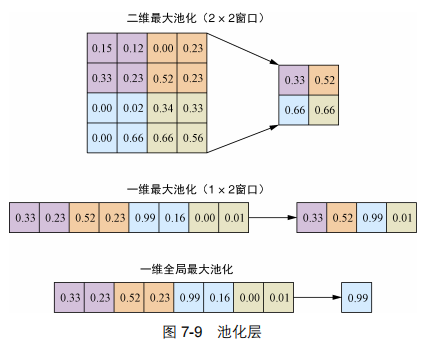

### 全连接层
将当前的向量传入一个标准的前馈网络，在 Keras 中就是 Dense 层。这里Dense 层中有 250 个神经元

In [ ]:
hidden_dims = 100 # 在普通的前馈网络中传播链端点的神经元的数量
model.add(Dense(hidden_dims))

### dropout层
dropout在Keras 中表示为一个层，是一种特殊的技术，用于防止神经网络中的过拟合。<br>
Keras中，Dropout 层接收的参数是输入数据随机关闭的比例。

In [ ]:
# 为每个训练样本随机选择 80%的嵌入数据按原样传递到下一层,参数一般为0.2
model.add(Dropout(0.2))

In [ ]:
#然后在每个神经元的输出端使用修正线性单元作为激活函数（relu）
model.add(Activation('relu'))

### 输出层
也是一个全连接神经网络

In [ ]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

### compile 完成模型的构建

In [ ]:

model.compile(loss='binary_crossentropy', #网络的训练目标是最小化损失函数 loss，在这里我们使用'binary_crossentropy'。
    optimizer='adam',     #optimizer 参数用于设置网络在训练阶段的一系列优化策略，包括随机梯度下降、Adam和 RSMProp 等
    metrics=['accuracy'])

In [ ]:
model.summary()
#  卷积层：250个卷积核，所以输出250，maxlen（150）-kernel_size(3)+1=148,250(卷积核个数)×300（embedding）×3+截距=225250
#  池化层：输出250个，和卷积核数目相同。变为 250 × 1
#  全连接层 ： 设置有100个神经元，参数为 100×250 + 100 =25100

### fit 完成模型的训练
训练过程中所有的操作，包括输入与权重相乘、激活函数、反向传播等都是由这一条语句启动的。

In [ ]:
#fit 完成模型的训练。
model.fit(x_train, y_train, 
        batch_size=30, 
        epochs = 16, 
        validation_data = (x_test, y_test))
# epochs = 2 整个训练数据集在网络中的传入次数
# Batch Size定义：一次训练所选取的样本数。

### 输出混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix = confusion_matrix(y_test, np.where(model.predict(x_test)>0.5,1,0),normalize="true")
print(confusion_matrix)

##  Keras 实现：测试样本

In [ ]:
sample = pd.Series(["I hate that the dismal weather had me down for so long","i think this movie is bad "])

In [ ]:
vector_sample = tokenize_and_vectorize(sample)
vector_sample = pad_trunc(vector_sample, 150)
vector_sample = np.array(vector_sample).astype(np.float32)
vector_sample.shape

In [ ]:
model.predict(vector_sample)# 输出确实是“负向”情感。

## 补充说明

1、CNN 在图像处理中有一个关键点是网络处理信息通道（channel）的能力。卷积核举例可为“3 像素宽×3 像素高×3 通道深”的形式。<br>
而自然语言处理网络的输入是一系列彼此相邻的的词，然后使用 Word2vec 嵌入作为词向量表示。前几章中有多种方式来生成词嵌入。如果选择多种词嵌入方式并将它们限制为相同的元素数，就可以把它们叠加起来像通道
那样。这种叠加各种词嵌入的方式会导致模型复杂度成倍增长，使训练时间变长，从而可能会得不偿失。

## 小结

1、神经网络可以像处理图像一样处理文本并“理解”它们。<br>
2、卷积是在一个大的数据集上滑动窗口（使关注点保持在整体的一个子集上）。<br>
3、用 dropout 来阻碍学习过程实际上是有帮助的。<br>
4、在 NLP 分类任务中选择 CNN 呢？它的主要好处是高效率。<br>

# 2.中文切词

## Jieba分词

1、__安装方式__<br>
很简单,输入__pip install jieba__命令即可以

2、__分词模式__<br>
<br>
__精确模式__：试图将句子最精确的分开，适合文本分析;<br>
__全模式__，把句子中所有可以成词的词语都扫描出来，速度非常快，但不能解决歧义;<br>
__搜索引擎模式__，在精确模式的基础上对长词再次切分，提高召回率，适合用户搜索引擎分词.<br>__paddle模式__，利用PaddlePaddle深度学习框架，训练序列标注（双向GRU）网络模型实现分词。同时支持词性标注。


3、 __代码示例__

In [44]:
import jieba
jieba.enable_paddle()# 启动paddle模式。 0.40版之后开始支持，早期版本不支持
content = "现如今，机器学习和深度学习带动人工智能飞速的发展，并在图片处理、语音识别领域取得巨大成功。"

Paddle enabled successfully......


In [45]:
cut_fullmode = "/".join(jieba.cut(content,cut_all=True))
print("【全模式】",cut_fullmode) 

【全模式】 现如今/如今/，/机器/学习/和/深度/学习/带动/动人/人工/人工智能/智能/飞速/的/发展/，/并/在/图片/处理/、/语音/识别/领域/取得/巨大/巨大成功/大成/成功/。


In [46]:
cut_Default = "/".join(jieba.cut(content,cut_all=False))
print("【精确模式】",cut_Default)

【精确模式】 现如今/，/机器/学习/和/深度/学习/带动/人工智能/飞速/的/发展/，/并/在/图片/处理/、/语音/识别/领域/取得/巨大成功/。


In [47]:
cut_for_search = "/".join(jieba.cut_for_search(content))
print("【搜索引擎模式】",cut_for_search)  

【搜索引擎模式】 如今/现如今/，/机器/学习/和/深度/学习/带动/人工/智能/人工智能/飞速/的/发展/，/并/在/图片/处理/、/语音/识别/领域/取得/巨大/大成/成功/巨大成功/。


In [48]:
cut_paddle = "/".join(jieba.cut(content,use_paddle=True))
print("【paddle模式】",cut_paddle) 

【paddle模式】 现如今/，/机器学习/和/深度学习/带动/人工智能/飞速/的/发展/，/并/在/图片/处理/、/语音/识别/领域/取得/巨大/成功/。


1、jieba.cut 以及 jieba.cut_for_search 返回的结构都是一个__可迭代的 generator__，可以使用 for 循环来获得分词后结果<br>
2、jieba.lcut 以及 jieba.lcut_for_search 直接返回 __list__<br>
3、待分词的字符串可以是 __unicode 或 UTF-8 字符串、GBK 字符串__。注意：不建议直接输入 GBK 字符串，可能无法预料地错误解码成 UTF-8

__4、获取词性__

jieba 可以很方便地获取中文词性，通过 jieba.posseg 模块实现词性标注。

In [49]:
import jieba.posseg as psg

In [50]:
print([(x.word,x.flag) for x in psg.lcut(content)])
# a：形容词；t：时间词；v：动词；w：标点符号；c:连词；vn：指具有名词功能的动词

[('现如今', 't'), ('，', 'x'), ('机器', 'n'), ('学习', 'v'), ('和', 'c'), ('深度', 'ns'), ('学习', 'v'), ('带动', 'v'), ('人工智能', 'n'), ('飞速', 'n'), ('的', 'uj'), ('发展', 'vn'), ('，', 'x'), ('并', 'c'), ('在', 'p'), ('图片', 'n'), ('处理', 'v'), ('、', 'x'), ('语音', 'n'), ('识别', 'v'), ('领域', 'n'), ('取得', 'v'), ('巨大成功', 'nr'), ('。', 'x')]


5、__自定义添加词和字典__

In [52]:
sentense = "蒜香咖啡是一种黑暗料理吗？"

默认情况下，使用默认分词，是识别不出这句话中的“蒜香咖啡”这个新词，这里使用用户字典提高分词准确性。

In [53]:
print(jieba.lcut(sentense))

['蒜', '香', '咖啡', '是', '一种', '黑暗', '料理', '吗', '？']


In [54]:
jieba.add_word("蒜香咖啡")    

In [55]:
print(jieba.lcut(sentense))

['蒜香咖啡', '是', '一种', '黑暗', '料理', '吗', '？']


但是，如果要添加很多个词，一个个添加效率就不够高了，这时候可以定义一个文件，然后通过 load_userdict()函数，加载自定义词典，

创建分词字典：创建一个dict.txt，然后写入你的分词,一个词占一行；每一行分三部分：词语、词频（可省略）、词性（可省略），用空格隔开，顺序不可颠倒。file_name 若为路径或二进制方式打开的文件，则文件必须为 UTF-8 编码。

In [62]:
# 在分词前通过jieba.load_userdict(file_name)来加载分词字典：
jieba.load_userdict('C:\\Users\\ASUS\\Desktop\\dict.txt')

In [63]:
print(jieba.lcut(sentense))

['蒜香咖啡', '是', '一种', '黑暗料理', '吗', '？']


In [ ]:
# 多分类、多个平行分类、内部平衡问题。
# 与科研、毕业论文相关
# 